Towards Data Science tutorial: https://towardsdatascience.com/twitter-data-collection-tutorial-using-python-3267d7cfa93e

**Description:** 

This is a sentiment analysis program that parses the tweets fetched from Twitter using Python. 

Account: Saint Laurent

In [1]:
# Import all needed libraries
import tweepy                   # Python wrapper around Twitter API
from google.colab import drive  # to mount Drive to Colab notebook
import json
import pandas as pd
import csv
from datetime import date
from datetime import datetime
import time
from textblob import TextBlob
from wordcloud import WordCloud
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Connect Google Drive to Colab
drive.mount('/content/gdrive')
# Create a variable to store the data path on your drive
path = './gdrive/My Drive/path/to/data'

Mounted at /content/gdrive


In [3]:
# Twitter API credentials

api_key = 'vpBT5zCco120S5VkWGeq0jbU3'
api_secret_key = 'nIk59NQikAS9kug5GcOkWuEqOqbAr1UgRhn5H77T9OiCdeEo7m'
access_token = '1362326919157583873-3NVcDUiiEBUsZGe06A7HzCTAs1tEDb'
access_token_secret = 'Y0Wrzi23jYd0TiAe9tNqQHax3PFqBrPRg2N2KQCl0rVtJ'


In [4]:
# Connect to Twitter API using the secrets
auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [5]:
# Helper function to save data into a JSON file
# file_name: the file name of the data on Google Drive
# file_content: the data you want to save
def save_json(file_name, file_content):
  with open(path + file_name, 'w', encoding='utf-8') as f:
    json.dump(file_content, f, ensure_ascii=False, indent=4)

In [6]:
# Helper function to handle twitter API rate limit
def limit_handled(cursor, list_name):
  while True:
    try:
      yield cursor.next()
    # Catch Twitter API rate limit exception and wait for 15 minutes
    except tweepy.RateLimitError:
      print("\nData points in list = {}".format(len(list_name)))
      print('Hit Twitter API rate limit.')
      for i in range(3, 0, -1):
        print("Wait for {} mins.".format(i * 5))
        time.sleep(5 * 60)
    # Catch any other Twitter API exceptions
    except tweepy.error.TweepError:
      print('\nCaught TweepError exception' )

### **The functions to get Tweets, Followers, Followings and Stats**


In [7]:
# Helper function to get all tweets of a specified user
# NOTE:This method only allows access to the most recent 3200 tweets
# Source: https://gist.github.com/yanofsky/5436496
def get_all_tweets(screen_name):
  # initialize a list to hold all the Tweets
  alltweets = []
  # make initial request for most recent tweets 
  # (200 is the maximum allowed count)
  new_tweets = api.user_timeline(screen_name = screen_name,count=200)
  # save most recent tweets
  alltweets.extend(new_tweets)
  # save the id of the oldest tweet less one to avoid duplication
  oldest = alltweets[-1].id - 1
  # keep grabbing tweets until there are no tweets left
  while len(new_tweets) > 0:
    print("getting tweets before %s" % (oldest))
    # all subsequent requests use the max_id param to prevent
    # duplicates
    new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
    # save most recent tweets
    alltweets.extend(new_tweets)
    # update the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    print("...%s tweets downloaded so far" % (len(alltweets)))
    ### END OF WHILE LOOP ###
  # transform the tweepy tweets into a 2D array that will 
  # populate the csv
  outtweets = [[tweet.id_str, tweet.created_at, tweet.text, tweet.favorite_count,tweet.in_reply_to_screen_name, tweet.retweeted] for tweet in alltweets]
  # write the csv
  with open(path + '%s_tweets.csv' % screen_name, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["id","created_at","text","likes","in reply to","retweeted"])
    writer.writerows(outtweets)
  pass

In [8]:
# Function to save follower objects in a JSON file.
def get_followers():
  
  # Create a list to store follower data
  followers_list = []
  # For-loop to iterate over tweepy cursors
  cursor = tweepy.Cursor(api.followers, count=200).pages()
  for i, page in enumerate(limit_handled(cursor, followers_list)):  
    print("\r"+"Loading"+ i % 5 *".", end='')
    
    # Add latest batch of follower data to the list
    followers_list += page
  
  # Extract the follower information
  followers_list = [x._json for x in followers_list]
  # Save the data in a JSON file
  save_json('followers_data.json', followers_list)

In [9]:
# Function to save friend objects in a JSON file.
def get_friends():
  
  # Create a list to store friends data
  friends_list = []
  # For-loop to iterate over tweepy cursors
  cursor = tweepy.Cursor(api.friends, count=200).pages()
  for i, page in enumerate(limit_handled(cursor, friends_list)):  
    print("\r"+"Loading"+ i % 5 *".", end='')
    
    # Add latest batch of friend data to the list
    friends_list += page
  
  # Extract the friends information
  friends_list = [x._json for x in friends_list]
  # Save the data in a JSON file
  save_json('friends_data.json', friends_list)

In [10]:
# Function to save daily follower and following counts in a JSON file
def todays_stats(dict_name):
  # Get my account information
  info = api.me()
  # Get follower and following counts
  followers_cnt = info.followers_count  
  following_cnt = info.friends_count
  # Get today's date
  today = date.today()
  d = today.strftime("%b %d, %Y")
  # Save today's stats only if they haven't been collected before
  if d not in dict_name:
    dict_name[d] = {"followers":followers_cnt, "following":following_cnt}
    save_json("follower_history.json", dict_name)
  else:
    print('Today\'s stats already exist')

###**Specific application to my Case Study: Gucci**

In [17]:
# initialize a list to hold all the Tweets
alltweets = []
# make initial request for most recent tweets 
# (200 is the maximum allowed count)
new_tweets = api.user_timeline(screen_name = "ysl",count=200)
# save most recent tweets
alltweets.extend(new_tweets)
# save the id of the oldest tweet less one to avoid duplication
oldest = alltweets[-1].id - 1
# keep grabbing tweets until there are no tweets left
while len(new_tweets) > 0:
  print("getting tweets before %s" % (oldest))
  # all subsequent requests use the max_id param to prevent
  # duplicates
  new_tweets = api.user_timeline(screen_name = "ysl",count=200,max_id=oldest)
  # save most recent tweets
  alltweets.extend(new_tweets)
  # update the id of the oldest tweet less one
  oldest = alltweets[-1].id - 1
  print("...%s tweets downloaded so far" % (len(alltweets)))
  ### END OF WHILE LOOP ###

# transform the tweepy tweets into a df 
# populate the csv
outtweets = [[tweet.id_str, tweet.created_at, tweet.text, tweet.favorite_count,tweet.in_reply_to_screen_name, tweet.retweeted] for tweet in alltweets]
# create df
dftweets = pd.DataFrame(outtweets, columns=["id","created_at","text","likes","in reply to","retweeted"])
dftweets.head()

getting tweets before 1394956021668491263
...400 tweets downloaded so far
getting tweets before 1247801346972979202
...600 tweets downloaded so far
getting tweets before 1039921801361608705
...800 tweets downloaded so far
getting tweets before 942752484279443457
...1000 tweets downloaded so far
getting tweets before 708232322542395391
...1200 tweets downloaded so far
getting tweets before 658979753114914815
...1400 tweets downloaded so far
getting tweets before 610436398634696703
...1600 tweets downloaded so far
getting tweets before 483313320146247679
...1788 tweets downloaded so far
getting tweets before 75973210037960703
...1788 tweets downloaded so far


,id,created_at,text,likes,in reply to,retweeted
0,1454131009948028928,2021-10-29 17:00:23,Halloween\nExclusively available at\nSaint Lau...,420,None,False
1,1453995032827121666,2021-10-29 08:00:04,"Skull Pendant Necklace, Nanoblock Skeleton, Na...",303,None,False
2,1453632636572737538,2021-10-28 08:00:02,Skull Paperweight\nHalloween\nExclusively avai...,317,None,False
3,1453401101860884489,2021-10-27 16:40:00,Halloween\nExclusively available at\nSaint Lau...,392,None,False
4,1453058904699523075,2021-10-26 18:00:14,Le Fermoir - Winter 21\nby Anthony Vaccarello\...,380,None,False


In [18]:
dftweets.shape

(1788, 6)

In [19]:
# Clean the text

# Create a function to clean the tweets

def cleanTxt(text):
  text = re.sub(r'@[A-Za-z0-9_]+', '', text) #Revoming @mentions
  text = re.sub(r'#', '', text) # Removing the '#' simbol
  text = re.sub(r'RT[\s]+', '', text) # Removing RT
  text = re.sub(r'https?:\/\/\S+', '', text) # Removing the hyper link

  return text

# Cleaning the text
dftweets['text'] = dftweets['text'].apply(cleanTxt)

# Show the cleaned text
dftweets.head()

,id,created_at,text,likes,in reply to,retweeted
0,1454131009948028928,2021-10-29 17:00:23,Halloween\nExclusively available at\nSaint Lau...,420,None,False
1,1453995032827121666,2021-10-29 08:00:04,"Skull Pendant Necklace, Nanoblock Skeleton, Na...",303,None,False
2,1453632636572737538,2021-10-28 08:00:02,Skull Paperweight\nHalloween\nExclusively avai...,317,None,False
3,1453401101860884489,2021-10-27 16:40:00,Halloween\nExclusively available at\nSaint Lau...,392,None,False
4,1453058904699523075,2021-10-26 18:00:14,Le Fermoir - Winter 21\nby Anthony Vaccarello\...,380,None,False


In [20]:
# Create a function to get the subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

# Create two new columns
dftweets['Subjectivity'] = dftweets['text'].apply(getSubjectivity)
dftweets['Polarity'] = dftweets['text'].apply(getPolarity)

# Show the new dataframe with the new columns
dftweets.head()

,id,created_at,text,likes,in reply to,retweeted,Subjectivity,Polarity
0,1454131009948028928,2021-10-29 17:00:23,Halloween\nExclusively available at\nSaint Lau...,420,None,False,0.4,0.4
1,1453995032827121666,2021-10-29 08:00:04,"Skull Pendant Necklace, Nanoblock Skeleton, Na...",303,None,False,0.4,0.4
2,1453632636572737538,2021-10-28 08:00:02,Skull Paperweight\nHalloween\nExclusively avai...,317,None,False,0.4,0.4
3,1453401101860884489,2021-10-27 16:40:00,Halloween\nExclusively available at\nSaint Lau...,392,None,False,0.4,0.4
4,1453058904699523075,2021-10-26 18:00:14,Le Fermoir - Winter 21\nby Anthony Vaccarello\...,380,None,False,0.0,0.0


<function matplotlib.pyplot.show>

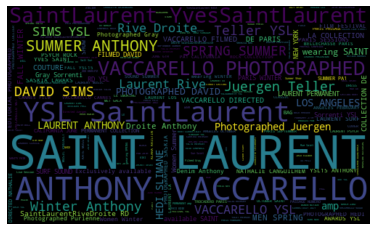

In [21]:
# Plot the Word Cloud
allWords = ' '.join( [twts for twts in dftweets['text']] )
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show

In [22]:
# Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

dftweets['Analysis'] = dftweets['Polarity'].apply(getAnalysis)

# Show the dataframe
dftweets.head()

,id,created_at,text,likes,in reply to,retweeted,Subjectivity,Polarity,Analysis
0,1454131009948028928,2021-10-29 17:00:23,Halloween\nExclusively available at\nSaint Lau...,420,None,False,0.4,0.4,Positive
1,1453995032827121666,2021-10-29 08:00:04,"Skull Pendant Necklace, Nanoblock Skeleton, Na...",303,None,False,0.4,0.4,Positive
2,1453632636572737538,2021-10-28 08:00:02,Skull Paperweight\nHalloween\nExclusively avai...,317,None,False,0.4,0.4,Positive
3,1453401101860884489,2021-10-27 16:40:00,Halloween\nExclusively available at\nSaint Lau...,392,None,False,0.4,0.4,Positive
4,1453058904699523075,2021-10-26 18:00:14,Le Fermoir - Winter 21\nby Anthony Vaccarello\...,380,None,False,0.0,0.0,Neutral


In [23]:
# Print all of the positive tweets
j=1
sortedDF = dftweets.sort_values(by=['Polarity'])
for i in range(0, 20):
  if (sortedDF['Analysis'][i] == 'Positive'):
    print(str(j) + ') ' + sortedDF['text'][i])
    print()
    j = j+1

1) Halloween
Exclusively available at
Saint Laurent Rive Droite
by Anthony Vaccarello
Artwork by Friedrich van Schoor… 

2) Skull Pendant Necklace, Nanoblock Skeleton, Nanoblock Pumpkin &amp; Skeleton Keyring
Halloween
Exclusively available at… 

3) Skull Paperweight
Halloween
Exclusively available at
Saint Laurent Rive Droite
by Anthony Vaccarello

213 Rue Saint… 

4) Halloween
Exclusively available at
Saint Laurent Rive Droite
by Anthony Vaccarello

213 Rue Saint-Honoré, Paris
469… 



In [24]:
# Print the negative tweets
j=1
sortedDF = dftweets.sort_values(by=['Polarity'], ascending='False')
for i in range(0, 20):
  if (sortedDF['Analysis'][i] == 'Negative'):
    print(str(j) + ') ' + sortedDF['text'][i])
    print()
    j = j+1

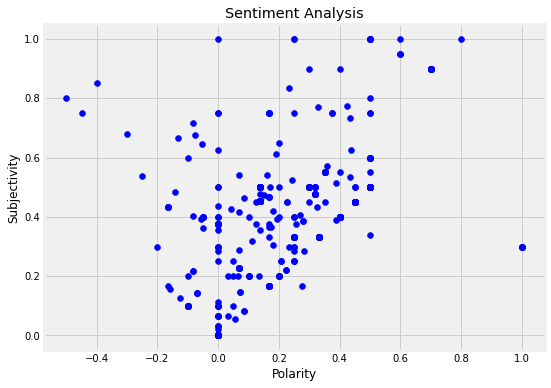

In [25]:
# Plot the polarity and subjectivity
plt.figure(figsize=(8,6))
for i in range(0, dftweets.shape[0]):
  plt.scatter(dftweets['Polarity'][i], dftweets['Subjectivity'][i], color='Blue')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [26]:
# Get the percentage of positive tweets
ptweets = dftweets[dftweets.Analysis == 'Positive']
ptweets = ptweets['text']

round((ptweets.shape[0] / dftweets.shape[0])*100, 1)

29.4

In [27]:
# Get the percentage of negative tweets
ptweets = dftweets[dftweets.Analysis == 'Negative']
ptweets = ptweets['text']

round((ptweets.shape[0] / dftweets.shape[0])*100, 1)

2.5

In [28]:
# Get the percentage of neutral tweets
ptweets = dftweets[dftweets.Analysis == 'Neutral']
ptweets = ptweets['text']

round((ptweets.shape[0] / dftweets.shape[0])*100, 1)

68.2

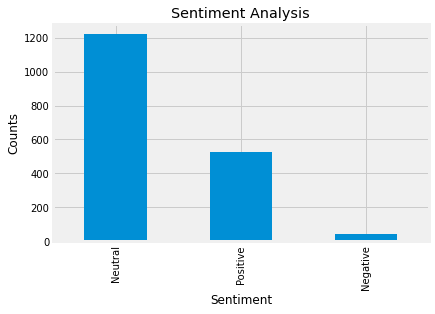

In [29]:
# Show the value counts
dftweets['Analysis'].value_counts()

# Plot and visualize the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
dftweets['Analysis'].value_counts().plot(kind='bar')
plt.show()

Really interesting, we can see here the difference with Gucci. The results relate to the Brand Image of Saint Laurent which is less extravagant then Gucci. Therefore, we can see that most of the Tweets are neutral.

In [30]:
dftweets.to_csv('/content/gdrive/MyDrive/Final Project/YSLTweets.csv', index=False)